# Nigeria/Africa Covid-19 Analysis
In this notebook, the effects of the covid-19 pandemic on the world will be reviewed with special attention given to Africa; Nigeria in particular. This study will be presented as follows:
<ul>
    <li><a href="#Imports">Package Importations, Dataset Overview</a></li>
    <li><a href="#Plotworldmap">Plotting and Studying Covid-19 in the Worldmap</a></li>
    <li><a href="#Plotcontinents">Plotting and Studying Covid-19 Based on Continents</a></li>
    <li><a href="#bgd">Determining Beta, Gamma and Delta</a></li>
    <li><a href="#R0">Finding R0 for Continents of Interest</a></li>
    <li><a href="#SIRD">Susceptibile - Immune- Recovered - Death (SIRD Models) for the World, Africa and Nigeria</a></li>
    <li><a href="#ntsa_sird">Sird Models for Nigeria, Tanzania and South Africa</a></li>
    <li><a href="#n_R0">Find R0 For Nigeria</a></li>
</ul>

## Package Imports and Dataset Overview
<a id="Imports"></a>

In [1]:
import numpy as np #for calculations in linear algebra
import pandas as pd #for processing reading csv file and processing data
import seaborn as sb #for smoother exploration and plotting
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels as sm
import folium as fl
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import scipy as sp
from pathlib import Path
from sklearn.impute import SimpleImputer
import geopandas as gpd
import mapclassify as mpc
import warnings
import plotly.offline as py
import plotly.express as px
import cufflinks as cf

%matplotlib inline

In [2]:
pd.options.plotting.backend
gpd.plotting.plot_linestring_collection
py.init_notebook_mode(connected = False)
cf.set_config_file(offline = True)
sb.set()
warnings.filterwarnings("ignore")

In [3]:
#read cleaned dataframe; result of the the Data Cleaning Notebook
df = pd.read_csv('data/new_main.csv')

In [4]:
#add a final row for the last day of 2020 in Greenland
gl = pd.DataFrame([['North America', 'Greenland', '2020-12-31', 0, 0, 0, 0, 71.706936, -42.604303, 0]],
                  columns=['continent', 'country', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'latitude', 'longitude', 'recovered'],
                 index=[30653])
df = df.append(gl, ignore_index=True)
df.head()

continent      country        date  total_cases  new_cases  total_deaths  \
0      Asia  Afghanistan  2020-02-24            1          1             0   
1      Asia  Afghanistan  2020-02-25            1          0             0   
2      Asia  Afghanistan  2020-02-26            1          0             0   
3      Asia  Afghanistan  2020-02-27            1          0             0   
4      Asia  Afghanistan  2020-02-28            1          0             0   

   new_deaths  latitude  longitude  recovered  
0           0  33.93911  67.709953          0  
1           0  33.93911  67.709953          0  
2           0  33.93911  67.709953          0  
3           0  33.93911  67.709953          0  
4           0  33.93911  67.709953          0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55271 entries, 0 to 55270
Data columns (total 10 columns):
continent       55271 non-null object
country         55271 non-null object
date            55271 non-null object
total_cases     55271 non-null int64
new_cases       55271 non-null int64
total_deaths    55271 non-null int64
new_deaths      55271 non-null int64
latitude        55271 non-null float64
longitude       55271 non-null float64
recovered       55271 non-null int64
dtypes: float64(2), int64(5), object(3)
memory usage: 4.2+ MB


In [6]:
#infer the number of active cases from the other columns
df['active_cases'] = df['total_cases'] - df['total_deaths'] - df['recovered']
df.sample(5)

continent        country        date  total_cases  new_cases  \
12004    Africa  Cote d'Ivoire  2020-07-09        11750        246   
22797    Europe        Iceland  2020-11-20         5251         20   
25482      Asia          Japan  2020-05-14        16096         98   
49420      Asia         Taiwan  2020-12-03          686          1   
2619    Oceania      Australia  2020-06-01         7221         19   

       total_deaths  new_deaths   latitude   longitude  recovered  \
12004            79           1   7.539989   -5.547080       5752   
22797            26           1  64.963051  -19.020835       4993   
25482           742          16  36.204824  138.252924       9868   
49420             7           0  23.697810  120.960515        572   
2619            102          -1 -25.274398  133.775136       6626   

       active_cases  
12004          5919  
22797           232  
25482          5486  
49420           107  
2619            493

In [7]:
#replace countries with appropriate formats as should be in geopandas
replacement = ['Dem. Rep. Congo', 'United States of America', "Côte d'Ivoire", 'Central African Rep.', 'Eq. Guinea', 'eSwatini', 'Bosnia and Herz.', 'S. Sudan', 'Dominican Rep.']
former = ['Democratic Republic of Congo', 'United States', "Cote d'Ivoire", 'Central African Republic', 'Equatorial Guinea', 'Eswatini', 'Bosnia and Herzegovina', 'South Sudan', 'Dominica']

df = df.replace(to_replace=former, value=replacement)

## Plotting and Studying Covid-19 in the Worldmap
<a id="Plotworldmap"></a>

In [8]:
#get total number of recorded cases, deaths, recoveries and active cased per day
geodata = df.groupby('date')[['total_cases', 'total_deaths', 'recovered', 'active_cases']].agg('sum')
geodata.head()

total_cases  total_deaths  recovered  active_cases
date                                                          
2020-01-01            0             0          0             0
2020-01-02            0             0          0             0
2020-01-03            0             0          0             0
2020-01-04            0             0          0             0
2020-01-05            0             0          0             0

In [9]:
# print('Worldwide Statistics as at 31st December, 2020 \n')
print('Number of Countries Affected by Covid-19: {}'.format(len(df.country.unique())))
print('Total Cases Confirmed: {}'.format(geodata.total_cases[geodata.index == geodata.index.max()].values[-1]))
print('Total Recoveries Made: {}'.format(geodata.recovered[geodata.index == geodata.index.max()].values[-1]))
print('Total Deaths Recorded: {}'.format(geodata.total_deaths[geodata.index == geodata.index.max()].values[-1]))
print('Total Number of Active Cases: {}'.format(geodata.active_cases[geodata.index == geodata.index.max()].values[-1]))

Number of Countries Affected by Covid-19: 186
Total Cases Confirmed: 83284335
Total Recoveries Made: 46796063
Total Deaths Recorded: 1820801
Total Number of Active Cases: 34667471


In [10]:
#plot time series progression of covid-19 cases worldwide
geodata.total_cases.iplot(kind='bar', legend=True, colors='Blue', title='Novel Covid-19 Worldwide', yTitle='Total Cases')

In [11]:
#Convert dataframe to Geo dataframe
covid_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [12]:
covid_geo.head()

continent      country        date  total_cases  new_cases  total_deaths  \
0      Asia  Afghanistan  2020-02-24            1          1             0   
1      Asia  Afghanistan  2020-02-25            1          0             0   
2      Asia  Afghanistan  2020-02-26            1          0             0   
3      Asia  Afghanistan  2020-02-27            1          0             0   
4      Asia  Afghanistan  2020-02-28            1          0             0   

   new_deaths  latitude  longitude  recovered  active_cases  \
0           0  33.93911  67.709953          0             1   
1           0  33.93911  67.709953          0             1   
2           0  33.93911  67.709953          0             1   
3           0  33.93911  67.709953          0             1   
4           0  33.93911  67.709953          0             1   

                    geometry  
0  POINT (67.70995 33.93911)  
1  POINT (67.70995 33.93911)  
2  POINT (67.70995 33.93911)  
3  POINT (67.70995 33.93911)  
4  POINT (67.70995 33.93911)

In [13]:
#Set coordinate reference system (crs) to EPSG 4326
covid_geo.crs = 'epsg:4326'

In [14]:
covid_geo.isna().sum()

continent       0
country         0
date            0
total_cases     0
new_cases       0
total_deaths    0
new_deaths      0
latitude        0
longitude       0
recovered       0
active_cases    0
geometry        0
dtype: int64

In [15]:
#get statistics from the geopandas library
world_file = gpd.datasets.get_path('naturalearth_lowres') #Upload natural data map
world = gpd.read_file(world_file)
world.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [16]:
#group covid data according to country and date
covid = df.groupby(['country', 'date'])[['total_cases', 'total_deaths', 'recovered', 'active_cases']].agg('sum').reset_index()

In [17]:
#get the numbers at the end of the year
current_data = covid[covid.date == covid.date.max()]
current_data.head()

country        date  total_cases  total_deaths  recovered  \
311   Afghanistan  2020-12-31        51526          2191      41727   
622       Albania  2020-12-31        58316          1181      33634   
933       Algeria  2020-12-31        99610          2756      67127   
1238      Andorra  2020-12-31         8049            84       7432   
1525       Angola  2020-12-31        17553           405      11044   

      active_cases  
311           7608  
622          23501  
933          29727  
1238           533  
1525          6104

In [18]:
#merge the world statistics and the covid dataframe
merged_geo = world.merge(current_data[['date', 'country', 'total_cases', 'total_deaths', 'recovered', 'active_cases']],
                         left_on='name', right_on='country')

In [19]:
merged_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 162 entries, 0 to 161
Data columns (total 12 columns):
pop_est         162 non-null int64
continent       162 non-null object
name            162 non-null object
iso_a3          162 non-null object
gdp_md_est      162 non-null float64
geometry        162 non-null geometry
date            162 non-null object
country         162 non-null object
total_cases     162 non-null int64
total_deaths    162 non-null int64
recovered       162 non-null int64
active_cases    162 non-null int64
dtypes: float64(1), geometry(1), int64(5), object(5)
memory usage: 16.5+ KB


In [20]:
merged_geo.query('country == "Greenland"')

pop_est      continent       name iso_a3  gdp_md_est  \
20    57713  North America  Greenland    GRL      2173.0   

                                             geometry        date    country  \
20  POLYGON ((-46.76379 82.62796, -43.40644 83.225...  2020-12-31  Greenland   

    total_cases  total_deaths  recovered  active_cases  
20            0             0          0             0

In [21]:
#get total population by continent
merged_geo.groupby('continent')[[('pop_est')]].agg('sum').head(6)

pop_est
continent                
Africa         1215072985
Asia           4297322053
Europe          744294740
North America   569690285
Oceania          35856193
South America   418537818

Text(0.5, 1, 'WORLD POPULATION BY CONTINENT')

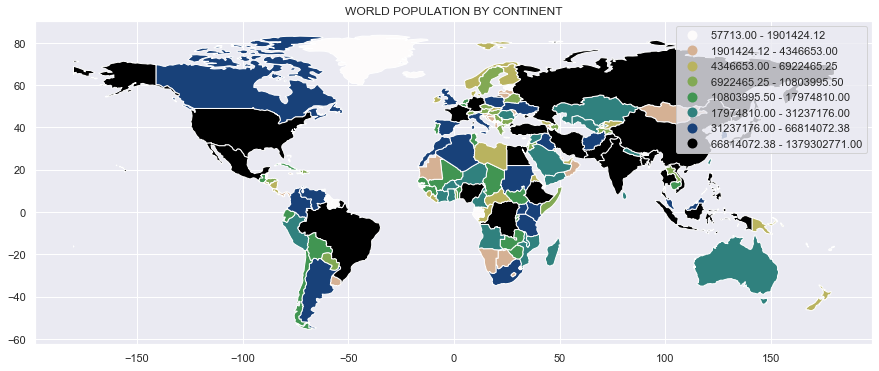

In [22]:
#plot population estimatates for each country
merged_geo.plot(cmap='gist_earth_r', column='pop_est', legend=True, figsize=(15,9), scheme='quantiles', k=8)
plt.title('WORLD POPULATION BY CONTINENT')

Text(0.5, 1, 'COVID 19 IN THE WORLD MAP')

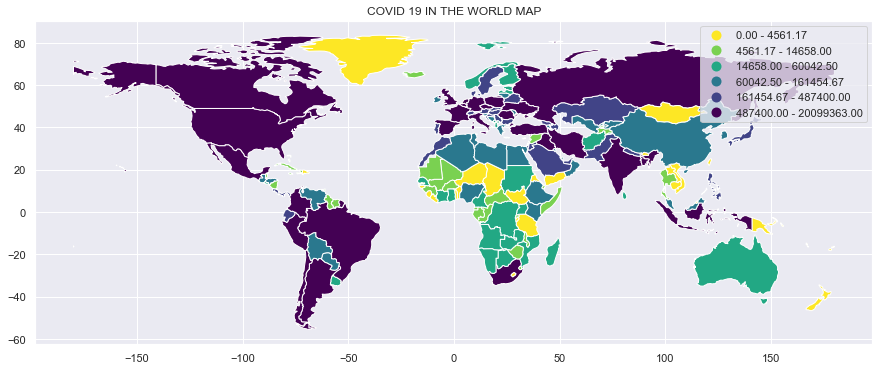

In [23]:
#plot total confirmed cases per country
merged_geo.plot(cmap='viridis_r', column='total_cases', legend=True, figsize=(15,9), scheme='quantiles', k=6)
plt.title('COVID 19 IN THE WORLD MAP')

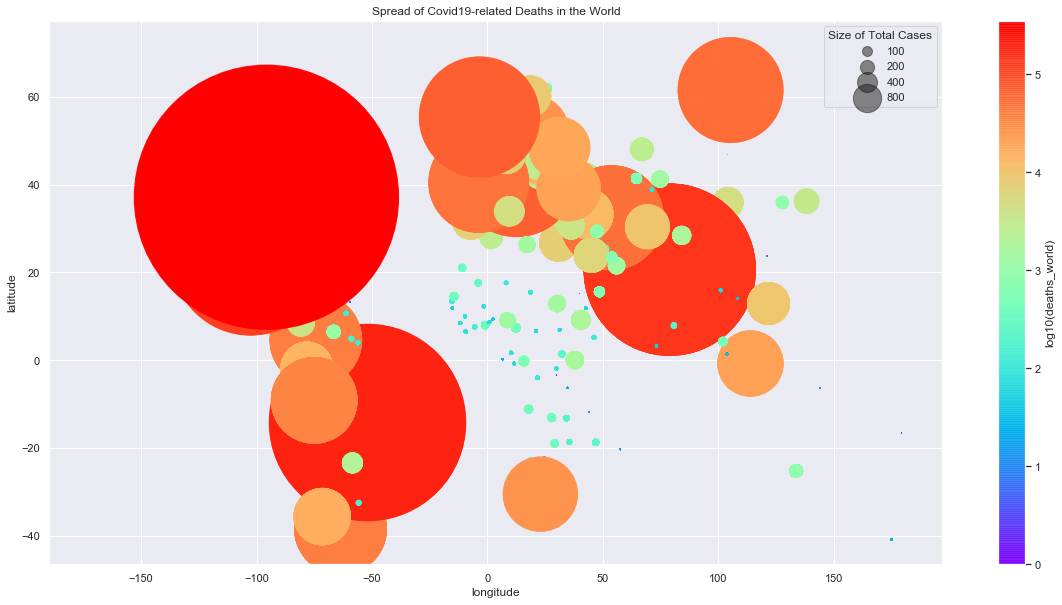

In [24]:
#plot recorded deaths on a logarithmic scale
pworld = covid_geo.copy()
lon_world = pworld.longitude
lat_world = pworld.latitude
deaths_world = pworld.total_deaths
plt.figure(figsize=(20,10))

plt.scatter(lon_world, lat_world, label=None, c=np.log10(deaths_world + 1), cmap='rainbow',
            s=deaths_world/5, linewidth=0, alpha=0.9)
plt.axis(aspect='equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label='log10(deaths_world)');

#plot size legend
for id in [100, 200, 400, 800]:
    plt.scatter([], [], c='k', alpha=0.5, s=id, label=str(id))
#add legend
plt.legend(scatterpoints=1, title='Size of Total Cases')
plt.title('Spread of Covid19-related Deaths in the World');

## Plotting and Studying Covid-19 Based on Continents
<a id="Plotcontinents"></a>

In [25]:
world.continent.unique()

array(['Oceania', 'Africa', 'North America', 'Asia', 'South America',
       'Europe', 'Seven seas (open ocean)', 'Antarctica'], dtype=object)

In [26]:
def covid_continent_numbers(continent=None, covid=covid, geo=merged_geo):
    '''This function takes in a continent and prints out the total confirmed cases, deaths, recoveries and active covid cases'''
    #con_map = variable for map of continents dataframe
    con_map = geo.loc[geo['continent'].isin([continent])]
    x = covid[covid['country'].isin(con_map.name)] #take country
    xdata = x.groupby('date')[['total_cases', 'recovered', 'total_deaths', 'active_cases']].agg('sum')
    day = xdata.index.max()
    country = x[x['date'] == day]
    cov2 = country.groupby('country')[['total_cases', 'recovered', 'total_deaths', 'active_cases']].agg('sum')
    corv = cov2.sort_values(by=['total_cases'], ascending=False)
    print('====== {}: COVID-19 Information of {} ======\n'.format(continent, day))
    print('Total Confirmed: {}'.format(corv.total_cases.sum()))
    print('Total Deaths: {}'.format(corv.total_deaths.sum()))
    print('Total Recoveries: {}'.format(corv.recovered.sum()))
    print('Total Active Cases: {}'.format(corv.active_cases.sum()))
    print('===================================================================\n')

In [27]:
#Select all continents in the dataframe besides the seven seas and Antarctica
xcols = list(set(world.continent.unique()) - set(['Seven seas (open ocean)', 'Antarctica']))

#Iterate through afore selected countries and apply function to each of them
for name in xcols:
    covid_continent_numbers(continent=name)

====== North America: COVID-19 Information of 2020-12-31 ======

Total Confirmed: 22898678
Total Deaths: 510602
Total Recoveries: 2180291
Total Active Cases: 20207785

====== Europe: COVID-19 Information of 2020-12-31 ======

Total Confirmed: 23675510
Total Deaths: 542461
Total Recoveries: 11288060
Total Active Cases: 11844989

====== Oceania: COVID-19 Information of 2020-12-31 ======

Total Confirmed: 31417
Total Deaths: 945
Total Recoveries: 25353
Total Active Cases: 5119

====== Africa: COVID-19 Information of 2020-12-31 ======

Total Confirmed: 2745999
Total Deaths: 65318
Total Recoveries: 2283804
Total Active Cases: 396877

====== South America: COVID-19 Information of 2020-12-31 ======

Total Confirmed: 13194159
Total Deaths: 362651
Total Recoveries: 11843822
Total Active Cases: 987686

====== Asia: COVID-19 Information of 2020-12-31 ======

Total Confirmed: 20289347
Total Deaths: 333020
Total Recoveries: 18793794
Total Active Cases: 1162533



In [28]:
def covid_continent(continent=None, covid = covid, covid_geo = covid_geo, geo = merged_geo):
    '''This function gives information in the evolution of COVID-19 in each continent.
    continent = name of continent
    covid = covid dataframe
    covid_geo = geospatial covid data
    geo = worldwide data
    
    
    returns each continent map bilan on covid-19 daily; plot confirmed curved; plot confirmed country
    
    con_map = variable for map of continents dataframe'''
    
    con_map = geo.loc[geo['continent'].isin([continent])]
    x = covid[covid['country'].isin(con_map.name)] #take country
    xdata = x.groupby('date')[['total_cases', 'recovered', 'total_deaths', 'active_cases']].agg('sum')
    day = xdata.index.max()
    country = x[x['date'] == day]
    cov2 = country.groupby('country')[['total_cases', 'recovered', 'total_deaths', 'active_cases']].agg('sum')
    corv = cov2.sort_values(by=['total_cases'], ascending=False)
    
    ax = con_map.plot(cmap='viridis_r', column='total_cases', legend=True, figsize=(18,18), scheme='quantiles', k=3)
    if continent == 'Oceania':
        ax.set_xlim([100, 200])
        ax.set_ylim([-50, 0])
    elif continent == 'Europe':
        ax.set_xlim([0, 90])
    
    plt.title('COVID-19 Confirmed Cases in {} Continent'.format(continent))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    fig = plt.figure(figsize=(15,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)
    xdata.plot(ax=ax1, legend=True, title='{} COVID-19 Time Evolution'.format(continent), colors=['b', 'g', 'r', 'orange'])
    corv.plot(ax=ax2, legend=True, kind='bar', title='COVID-19 Spread Across {} Continent'.format(continent), logy=True, colors=['b', 'g', 'r', 'orange'])
        
    ax=None
    map_cov=None
    xdata=None
    corv=None

In [29]:
#Group dtaframe to get African countries
x = covid[covid['country'].isin(merged_geo.loc[merged_geo['continent'].isin(['Africa'])].name)] #take country
xdata = x.groupby('date')[['total_cases', 'recovered', 'total_deaths', 'active_cases']].agg('sum')
day = xdata.index.max()
country = x[x['date'] == day]
cov2 = country.groupby('country')[['total_cases', 'recovered', 'total_deaths', 'active_cases']].agg('sum')

In [30]:
cov2.head()

total_cases  recovered  total_deaths  active_cases
country                                                         
Algeria             99610      67127          2756         29727
Angola              17553      11044           405          6104
Benin                3251       3061            44           146
Botswana            14805      12136            42          2627
Burkina Faso         6707       5100            85          1522

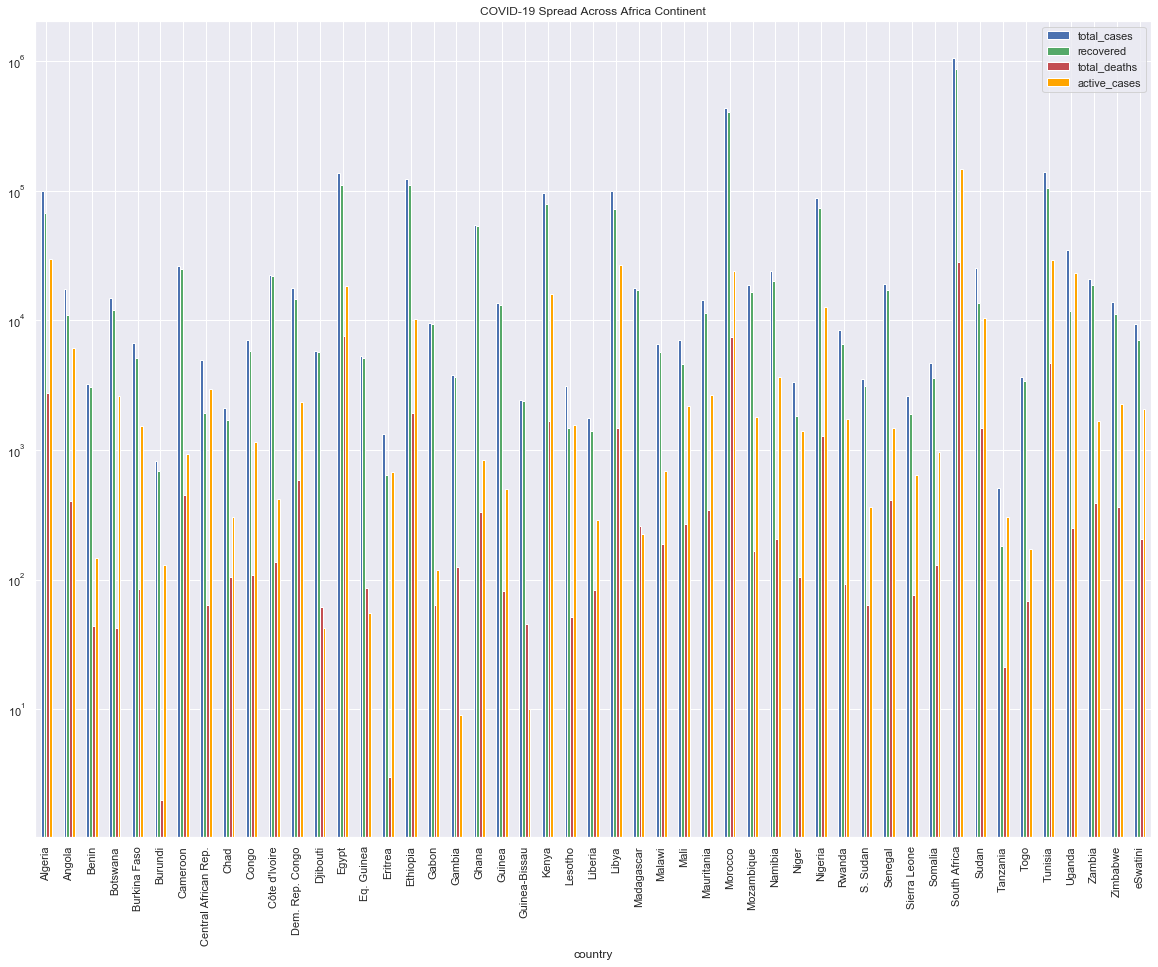

In [31]:
#plot covid-19 numbers for African Countries
cov2.plot(legend=True, kind='bar', title='COVID-19 Spread Across {} Continent'.format('Africa'), logy=True,
          colors=['b', 'g', 'r', 'orange'], figsize=(20,15))
scale_factor = 1000
ymin, ymax = plt.ylim()

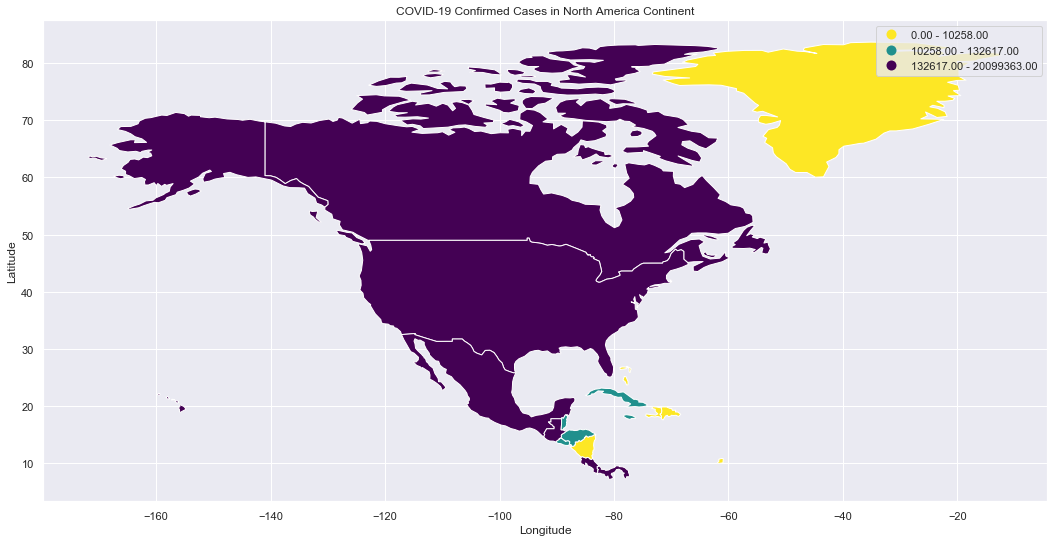

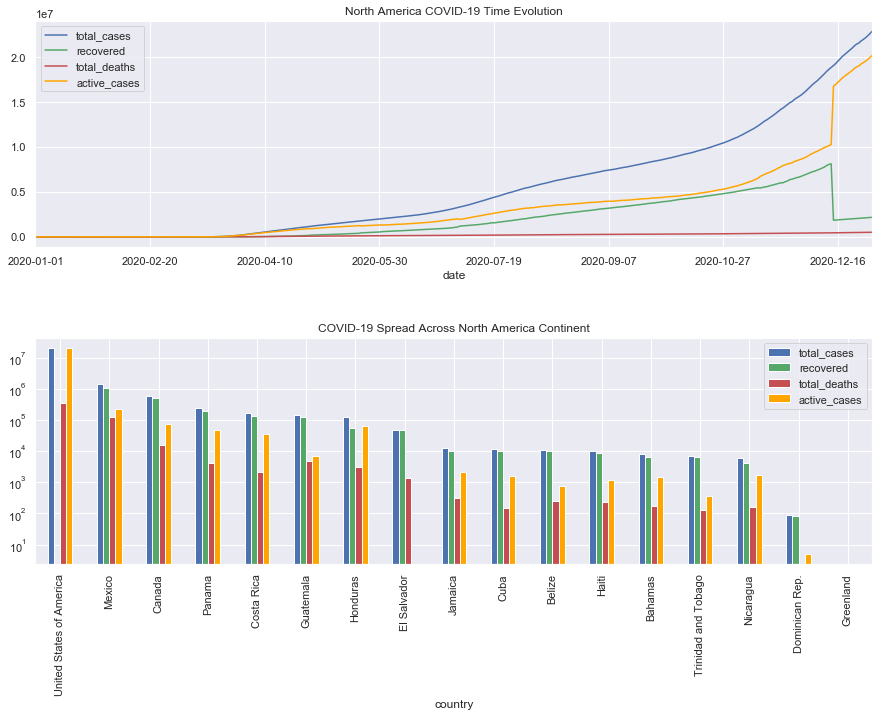

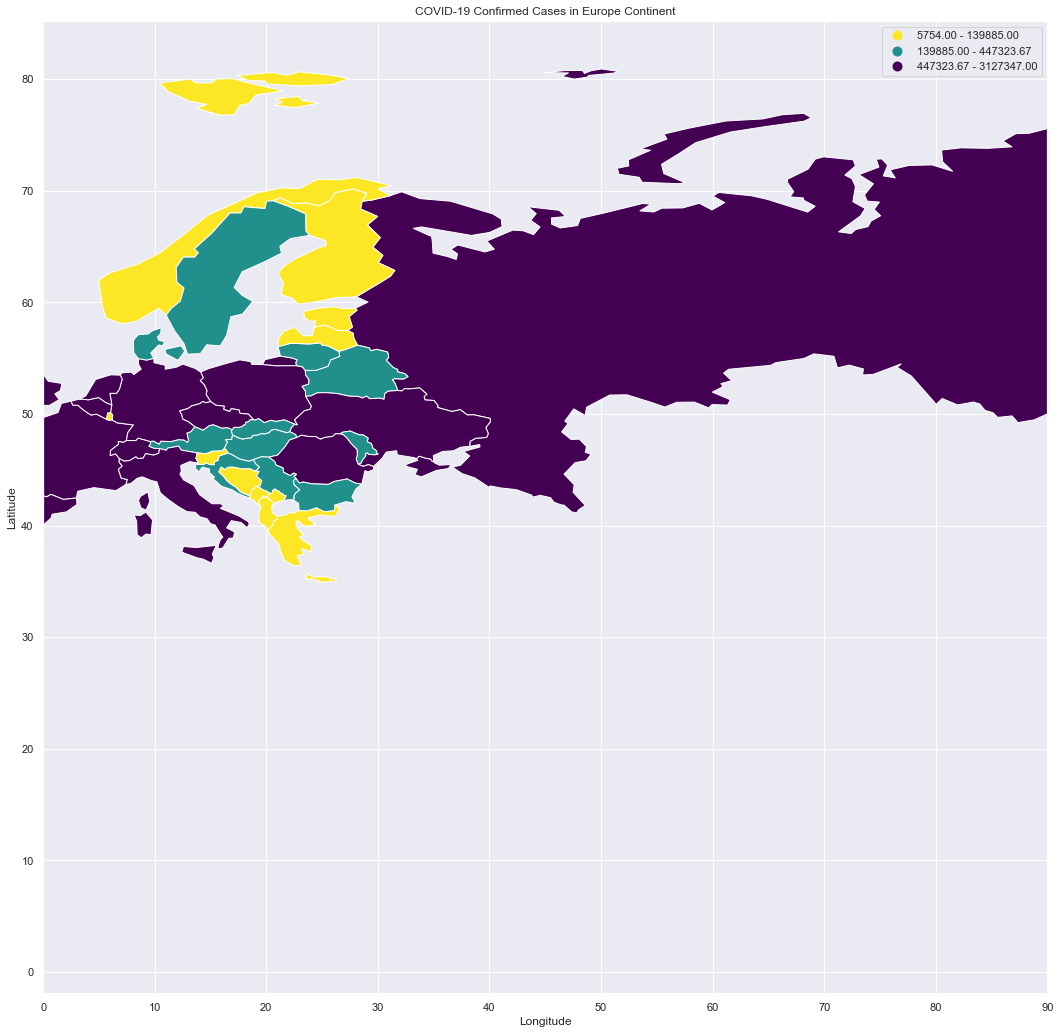

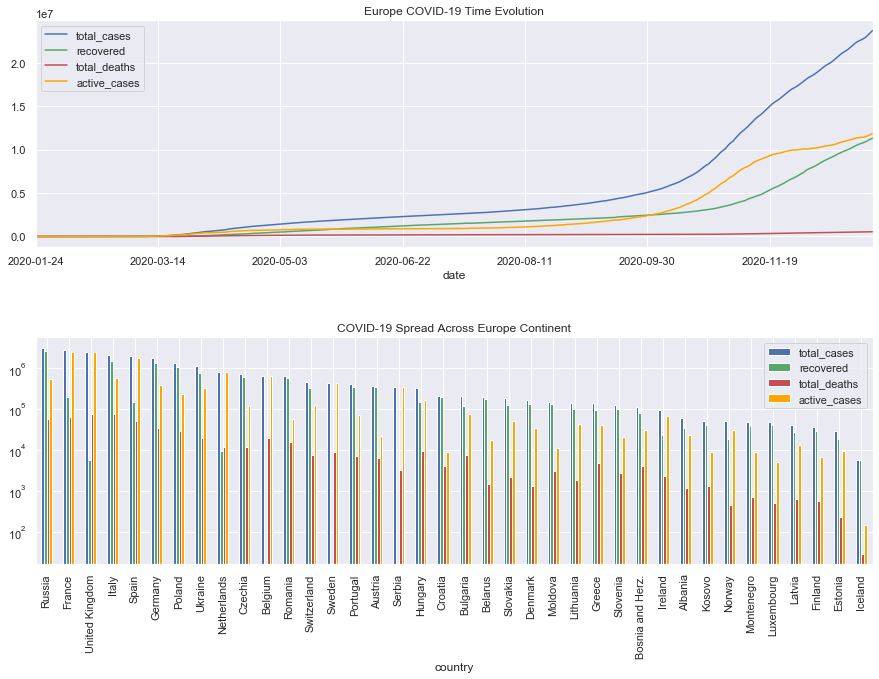

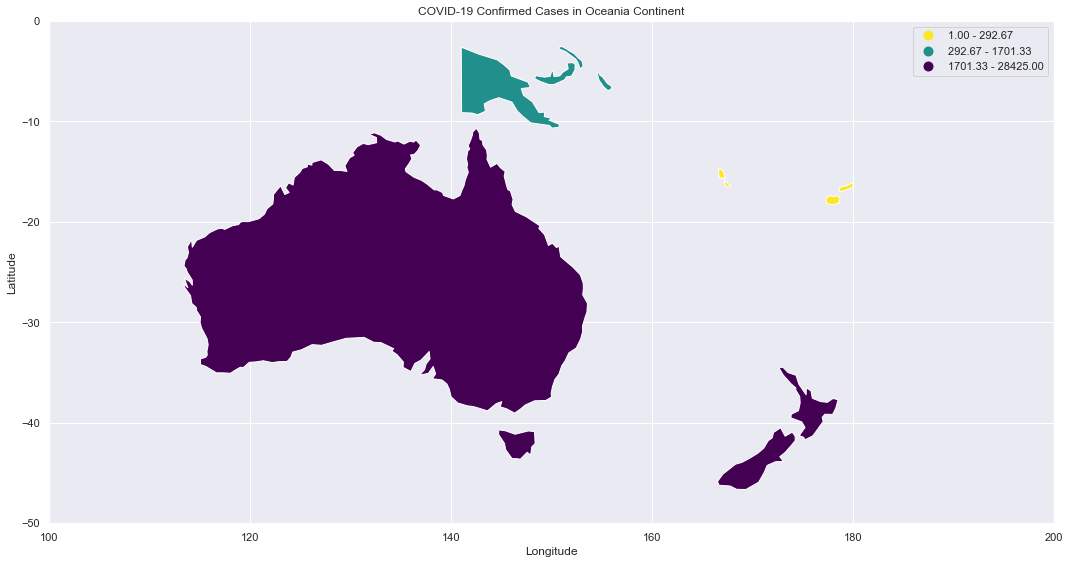

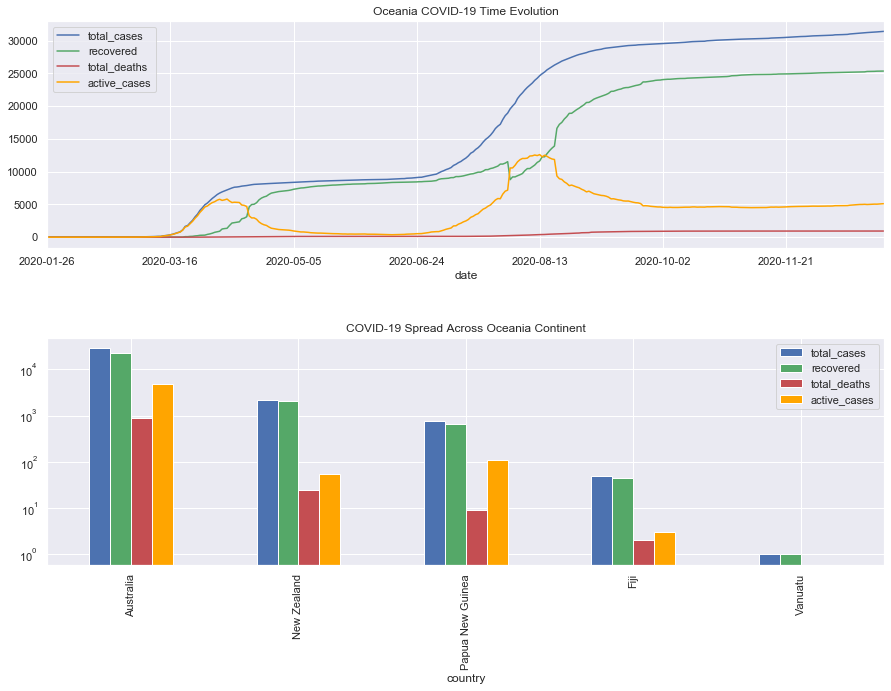

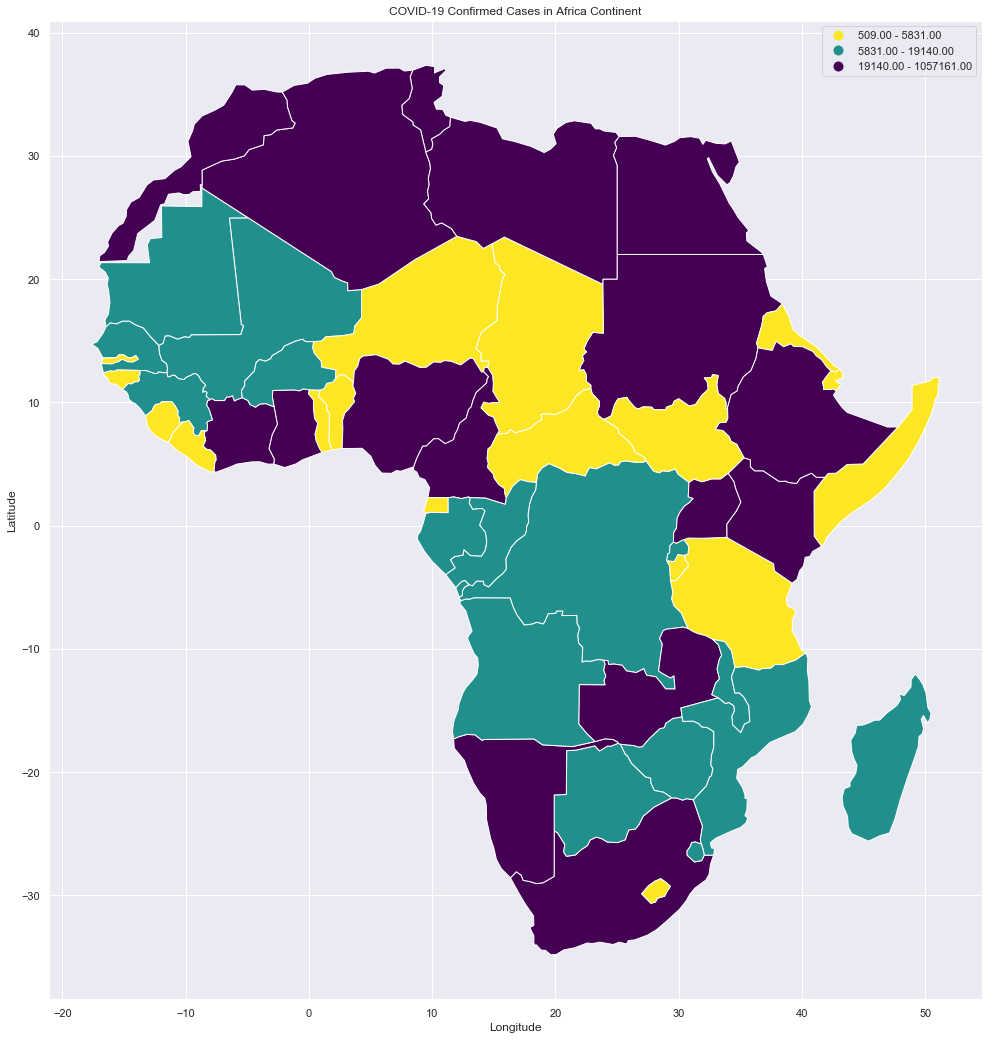

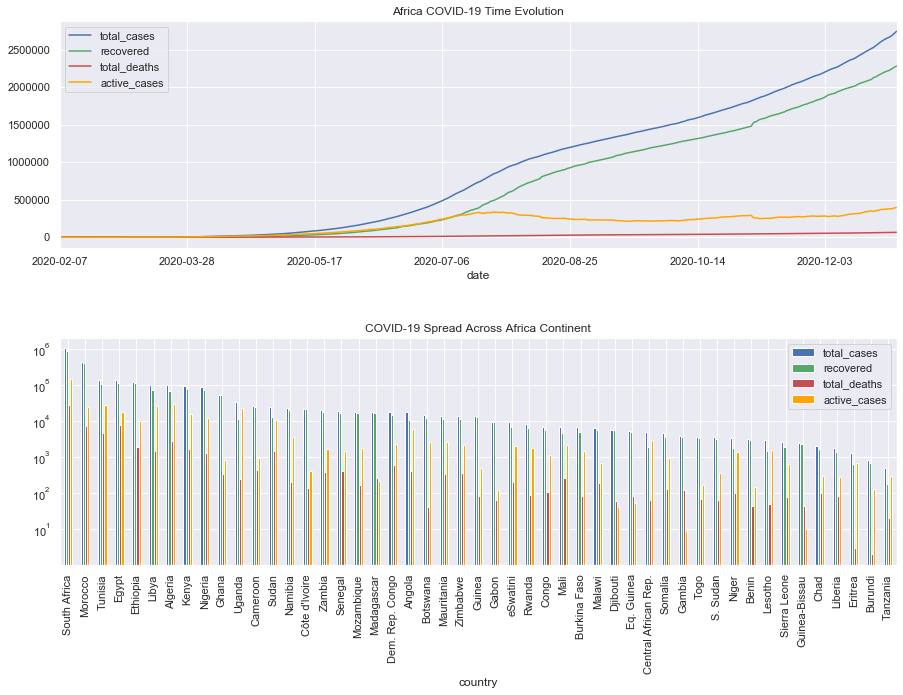

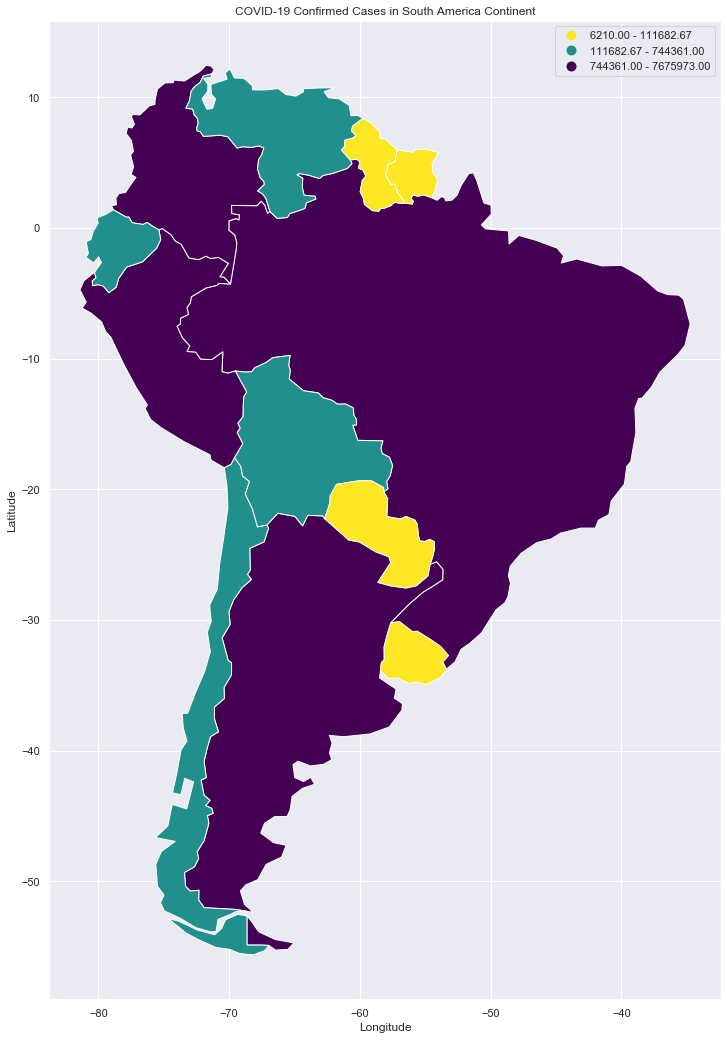

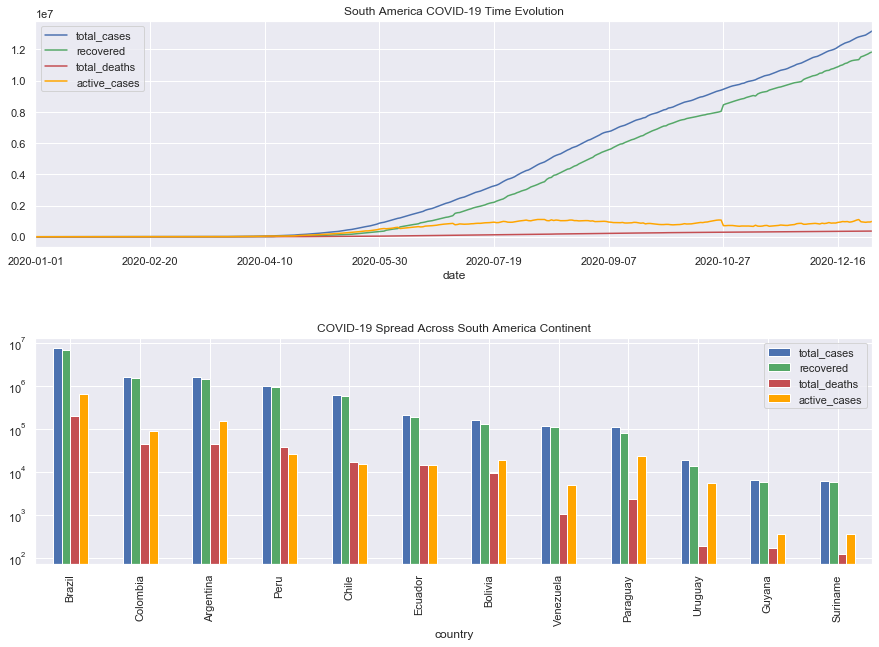

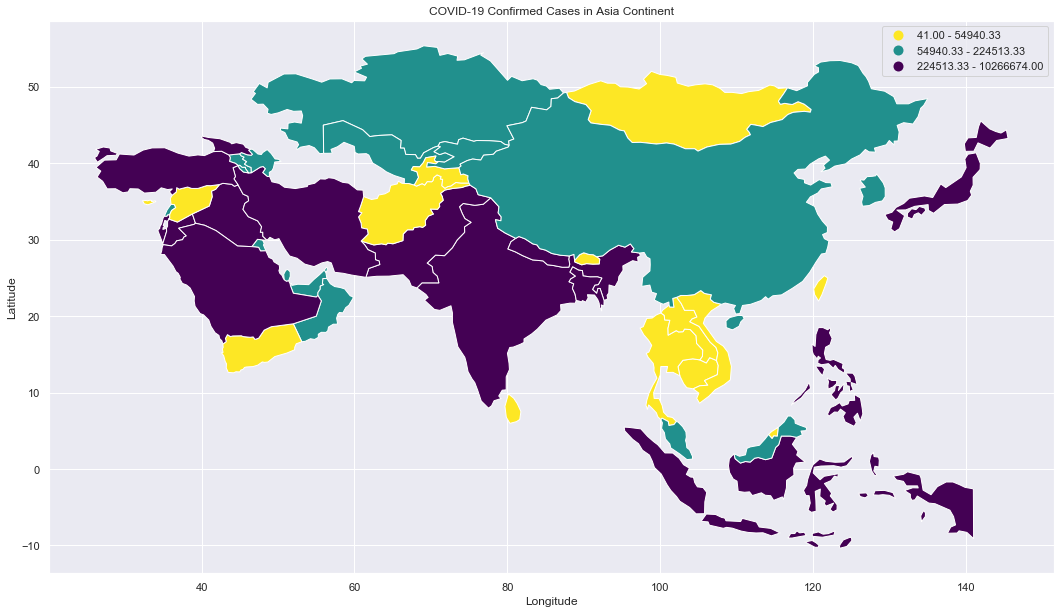

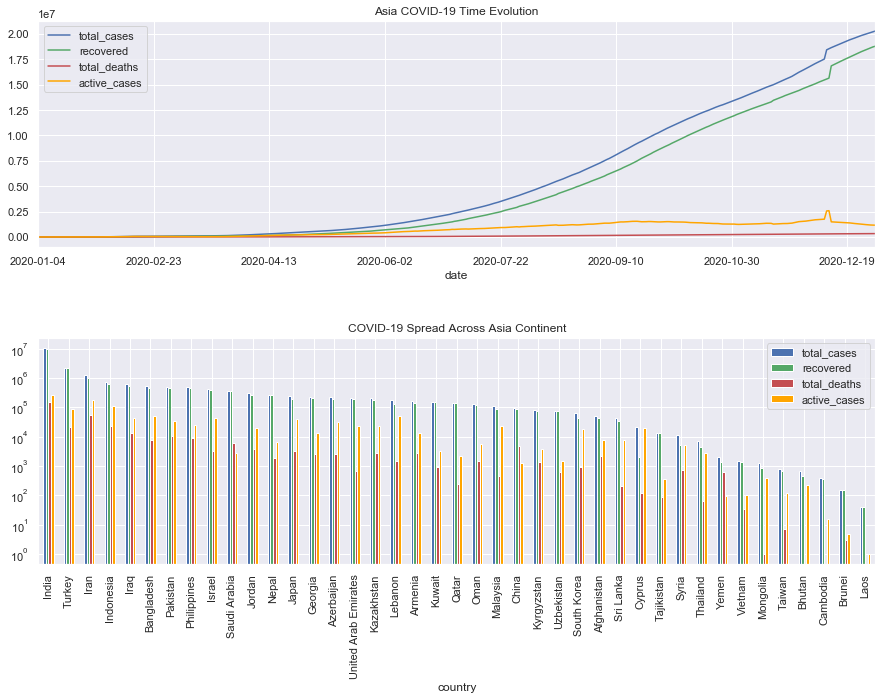

In [32]:
#Select all continents in the dataframe besides the seven seas and Antarctica
xcols = list(set(world.continent.unique()) - set(['Seven seas (open ocean)', 'Antarctica']))

#Iterate through afore selected countries and apply function to each of them
for name in xcols:
    covid_continent(continent=name)

## Determining Beta, Gamma and Delta

<a id="bgd"></a>


Before finding Beta, Gamma and Delta however, we will have to find the ratio between the number of confirmed cases in one continent and the population siz in that same continent at a particular time t

In [33]:
latest = geodata.index.max()

daily = merged_geo.loc[merged_geo.date.isin([latest])]

pop_size =  daily.groupby('continent')['pop_est'].agg('sum')

case_size = daily.groupby('continent')['total_cases'].agg('sum')

In [34]:
print('The number of positive Cases per Population Size at {} is: {}'.format(latest, case_size/pop_size))

The number of positive Cases per Population Size at 2020-12-31 is: continent
Africa           0.002260
Asia             0.004721
Europe           0.031809
North America    0.040195
Oceania          0.000876
South America    0.031524
dtype: float64


### Interpretation of Above Figures

While it may seem that Asia has the most cases, North America specifically has the most cases per populationsize. This can be interpreted as <br>
<ul>
    <li>For every 1000 people in Africa, approximately 2 people had contacted the virus</li>
    <li>For every 1000 people in Asia, approximately 5 people had contacted the virus</li>
    <li>For every 1000 people in Europe, approximately 32 people had contacted the virus</li>
    <li>For every 1000 people in North America, approximately 40 people had contacted the virus</li>
    <li>For every 1000 people in Oceania, approximately 1 person had contacted the virus</li>
    <li>For every 1000 people in South America, approximately 32 people had contacted the virus</li>
</ul>

##### We Can Approximate our SIRD Model Using:

In [35]:
def find_b_g_d(data=None):
    '''
        This function calculates transmission rate, recovery rate and death rate over time
        Parameters: Data
        Returns: beta, gamma, delta 
    '''
    beta = []
    gamma = []
    delta = []
    
    for i in range(len(data.date.values)):
        x = data.total_cases.iloc[i]
        y = data.total_deaths.iloc[i]
        z = data.recovered.iloc[i]
        w = data.active_cases.iloc[i]
        
        if x == 0:
            beta.append(0)
            gamma.append(0)
            delta.append(0)
        else:
            beta_i = w/x
            gamma_i = z/x
            delta_i = y/x
            
            beta.append(beta_i)
            gamma.append(gamma_i)
            delta.append(delta_i)
    
    return np.array(beta), np.array(gamma), np.array(delta)

In [36]:
merged_geo_2 = world.merge(df[['date', 'country', 'total_cases', 'total_deaths', 'recovered', 'active_cases']],
                         left_on='name', right_on='country')

geospatial = merged_geo_2.groupby(['date', 'name', 'continent'])['total_cases', 'total_deaths', 'recovered', 'active_cases'].agg('sum')

In [37]:
test = merged_geo_2.groupby(['date', 'name', 'continent'])['pop_est', 'total_cases', 'total_deaths', 'recovered', 'active_cases'].agg('sum')

In [38]:
test.head()

pop_est  total_cases  total_deaths  \
date       name      continent                                             
2020-01-01 Argentina South America   44293293            0             0   
           Mexico    North America  124574795            0             0   
2020-01-02 Argentina South America   44293293            0             0   
           Mexico    North America  124574795            0             0   
2020-01-03 Argentina South America   44293293            0             0   

                                    recovered  active_cases  
date       name      continent                               
2020-01-01 Argentina South America          0             0  
           Mexico    North America          0             0  
2020-01-02 Argentina South America          0             0  
           Mexico    North America          0             0  
2020-01-03 Argentina South America          0             0

In [39]:
test['susceptible'] = test.pop_est - test.total_deaths - test.recovered - test.active_cases
test = test.reset_index()
test.sample()

date          name continent   pop_est  total_cases  total_deaths  \
3797  2020-03-23  Burkina Faso    Africa  20107509           99             4   

      recovered  active_cases  susceptible  
3797          5            90     20107410

In [40]:
transmission1, recovery1, death1 = find_b_g_d(data=test)

test['beta'] = transmission1
test['gamma'] = recovery1
test['delta'] = death1

test.head()

date       name      continent    pop_est  total_cases  total_deaths  \
0  2020-01-01  Argentina  South America   44293293            0             0   
1  2020-01-01     Mexico  North America  124574795            0             0   
2  2020-01-02  Argentina  South America   44293293            0             0   
3  2020-01-02     Mexico  North America  124574795            0             0   
4  2020-01-03  Argentina  South America   44293293            0             0   

   recovered  active_cases  susceptible  beta  gamma  delta  
0          0             0     44293293   0.0    0.0    0.0  
1          0             0    124574795   0.0    0.0    0.0  
2          0             0     44293293   0.0    0.0    0.0  
3          0             0    124574795   0.0    0.0    0.0  
4          0             0     44293293   0.0    0.0    0.0

In [41]:
test = test.rename(columns = {'active_cases':'infective', 'total_deaths':'dead'})
test.head()

date       name      continent    pop_est  total_cases  dead  \
0  2020-01-01  Argentina  South America   44293293            0     0   
1  2020-01-01     Mexico  North America  124574795            0     0   
2  2020-01-02  Argentina  South America   44293293            0     0   
3  2020-01-02     Mexico  North America  124574795            0     0   
4  2020-01-03  Argentina  South America   44293293            0     0   

   recovered  infective  susceptible  beta  gamma  delta  
0          0          0     44293293   0.0    0.0    0.0  
1          0          0    124574795   0.0    0.0    0.0  
2          0          0     44293293   0.0    0.0    0.0  
3          0          0    124574795   0.0    0.0    0.0  
4          0          0     44293293   0.0    0.0    0.0

In [42]:
test['ds'] = (-test.beta * test.infective * test.susceptible)/test.pop_est
test['di'] = ((test.beta * test.infective)/test.pop_est) - ((test.gamma + test.delta) * test.infective)
test['dr'] = test.gamma * test.infective
test['dd'] = test.delta * test.infective

In [43]:
test2 = test.copy().groupby(['date', 'name'])[['dead', 'recovered', 'infective', 'susceptible', 'beta', 'gamma', 'delta']].agg('mean').reset_index()

test = test.groupby(['date', 'continent'])[['dead', 'recovered', 'infective', 'susceptible', 'beta', 'gamma', 'delta', 'ds', 'di', 'dr', 'dd']].agg('mean').reset_index()

In [44]:
test.head()

date      continent  dead  recovered  infective  susceptible  beta  \
0  2020-01-01  North America   0.0        0.0        0.0  124574795.0   0.0   
1  2020-01-01  South America   0.0        0.0        0.0   44293293.0   0.0   
2  2020-01-02  North America   0.0        0.0        0.0  124574795.0   0.0   
3  2020-01-02  South America   0.0        0.0        0.0   44293293.0   0.0   
4  2020-01-03  North America   0.0        0.0        0.0  124574795.0   0.0   

   gamma  delta   ds   di   dr   dd  
0    0.0    0.0  0.0  0.0  0.0  0.0  
1    0.0    0.0  0.0  0.0  0.0  0.0  
2    0.0    0.0  0.0  0.0  0.0  0.0  
3    0.0    0.0  0.0  0.0  0.0  0.0  
4    0.0    0.0  0.0  0.0  0.0  0.0

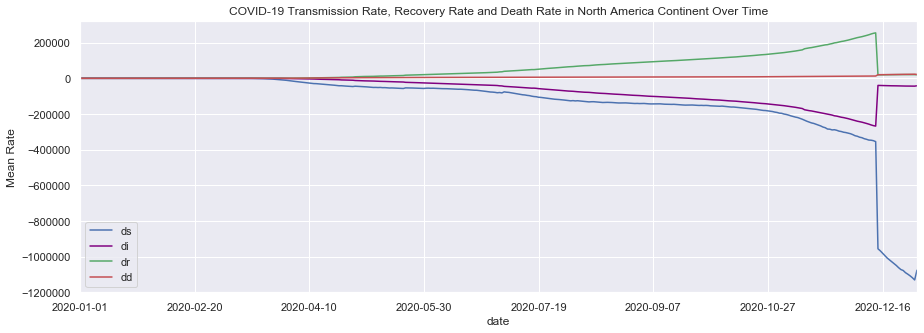

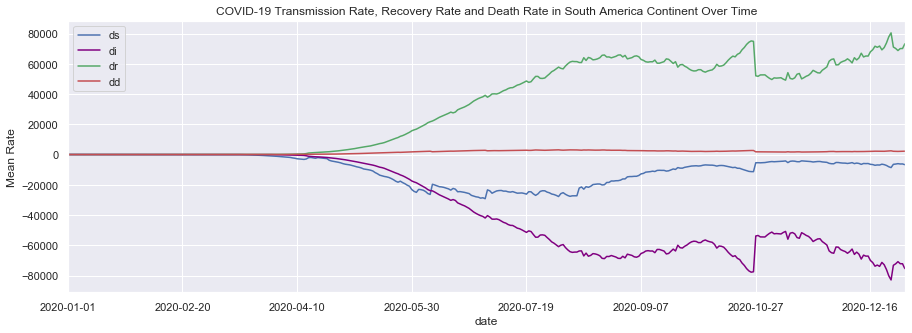

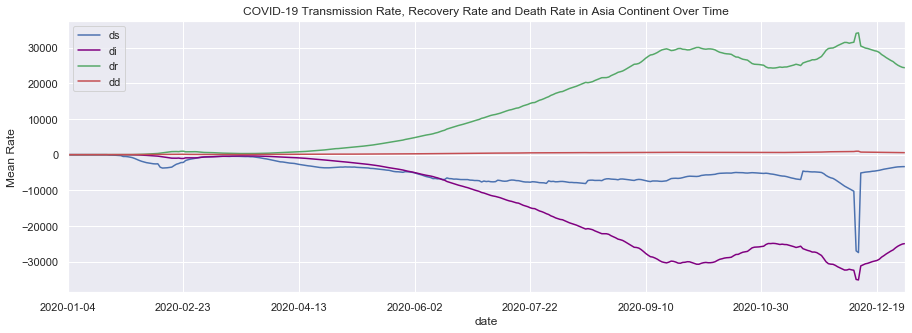

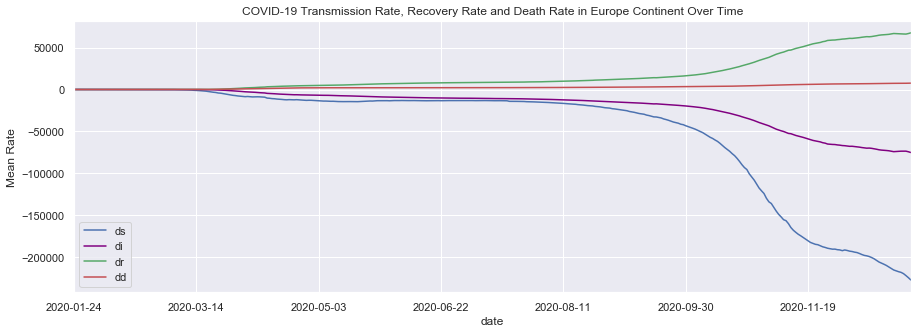

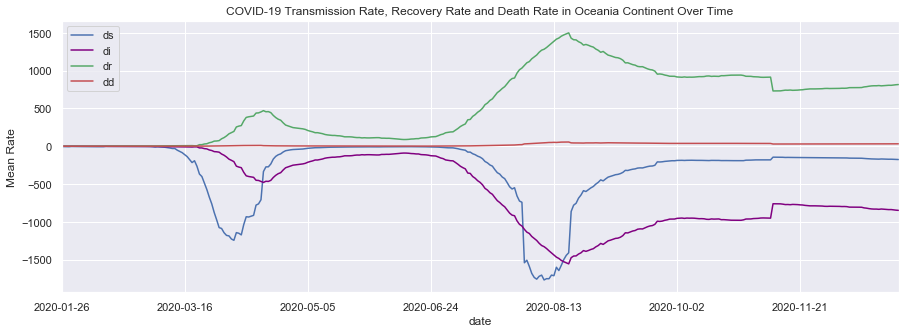

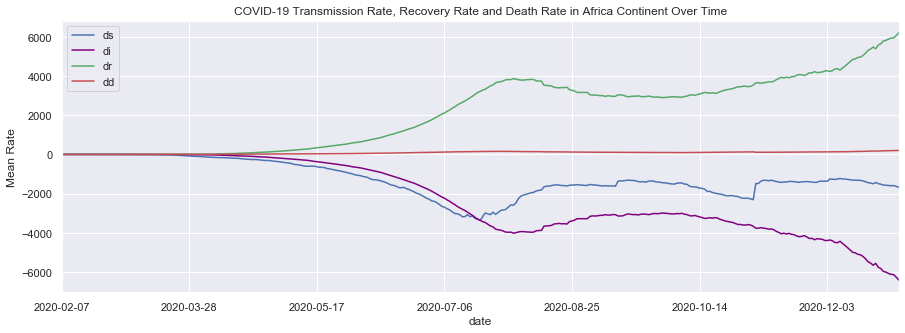

In [45]:
for i in test.continent.unique():
    surface = test[test.continent==i]
    surface = surface.drop(columns=['continent', 'dead', 'recovered', 'infective', 'susceptible', 'beta', 'gamma', 'delta'])
    surface.plot(x='date', title='COVID-19 Transmission Rate, Recovery Rate and Death Rate in {} Continent Over Time'.format(i),
                 figsize=(15,5), color=['b', 'purple', 'g', 'r'])
    plt.ylabel('Mean Rate')

In [46]:
geospa = geospatial.reset_index()
geospa.head()

date       name      continent  total_cases  total_deaths  recovered  \
0  2020-01-01  Argentina  South America            0             0          0   
1  2020-01-01     Mexico  North America            0             0          0   
2  2020-01-02  Argentina  South America            0             0          0   
3  2020-01-02     Mexico  North America            0             0          0   
4  2020-01-03  Argentina  South America            0             0          0   

   active_cases  
0             0  
1             0  
2             0  
3             0  
4             0

In [47]:
transmission, recovery, death = find_b_g_d(data=geospa)

In [48]:
geospa['beta'] = transmission
geospa['gamma'] = recovery
geospa['delta'] = death

geospa.head()

date       name      continent  total_cases  total_deaths  recovered  \
0  2020-01-01  Argentina  South America            0             0          0   
1  2020-01-01     Mexico  North America            0             0          0   
2  2020-01-02  Argentina  South America            0             0          0   
3  2020-01-02     Mexico  North America            0             0          0   
4  2020-01-03  Argentina  South America            0             0          0   

   active_cases  beta  gamma  delta  
0             0   0.0    0.0    0.0  
1             0   0.0    0.0    0.0  
2             0   0.0    0.0    0.0  
3             0   0.0    0.0    0.0  
4             0   0.0    0.0    0.0

#### Transmission Rate, Recovery Rate and Death Rate Worldwide

In [49]:
rate_map = geospa.groupby(['date', 'continent'])[['beta', 'gamma', 'delta']].agg('mean').reset_index()
rate_map.head(10)

date      continent  beta  gamma  delta
0  2020-01-01  North America   0.0    0.0    0.0
1  2020-01-01  South America   0.0    0.0    0.0
2  2020-01-02  North America   0.0    0.0    0.0
3  2020-01-02  South America   0.0    0.0    0.0
4  2020-01-03  North America   0.0    0.0    0.0
5  2020-01-03  South America   0.0    0.0    0.0
6  2020-01-04           Asia   0.0    0.0    0.0
7  2020-01-04  North America   0.0    0.0    0.0
8  2020-01-04  South America   0.0    0.0    0.0
9  2020-01-05           Asia   0.0    0.0    0.0

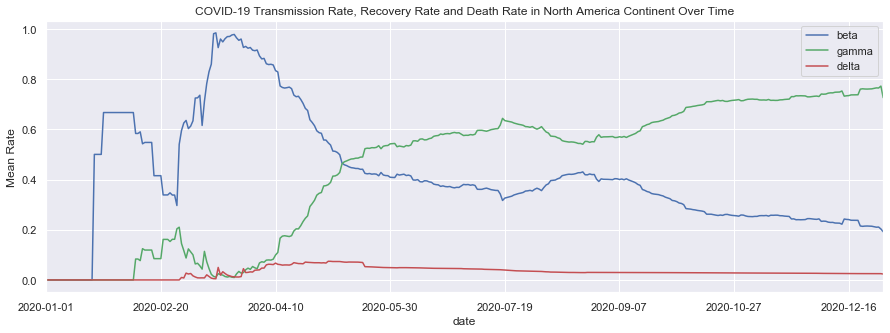

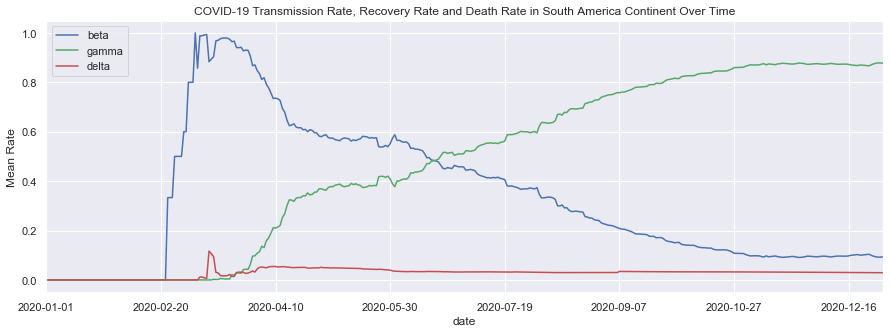

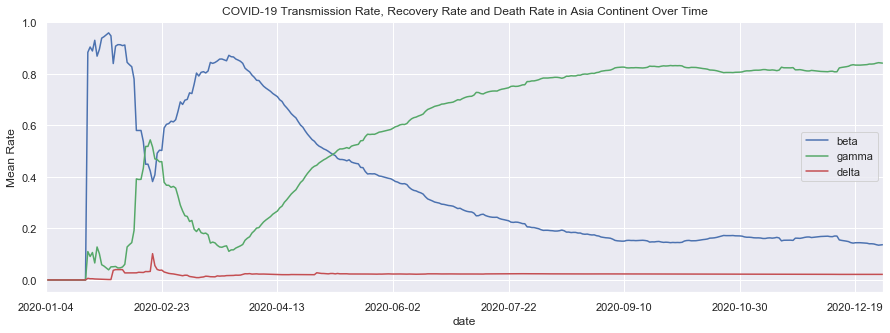

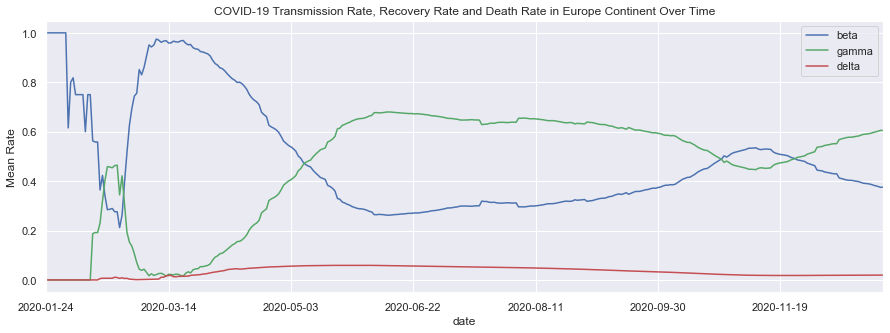

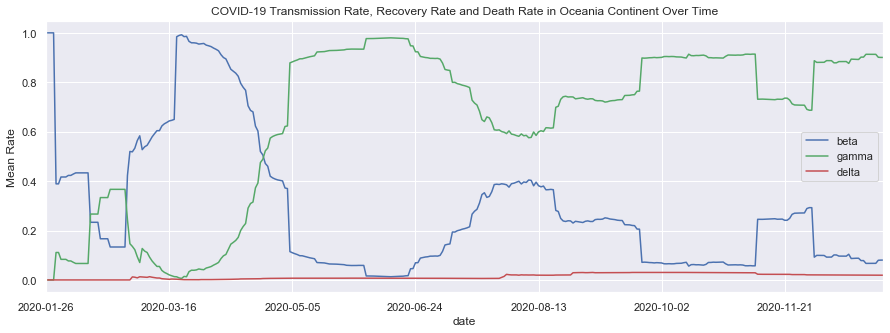

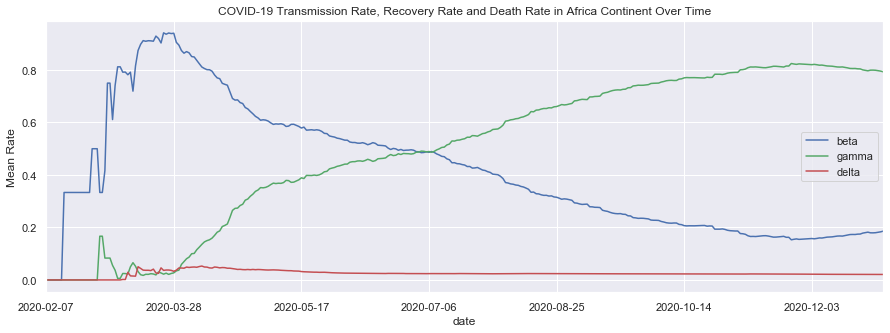

In [50]:
for i in rate_map.continent.unique():
    surface = rate_map[rate_map.continent==i]
    surface = surface.drop(columns='continent')
    surface.plot(x='date', title='COVID-19 Transmission Rate, Recovery Rate and Death Rate in {} Continent Over Time'.format(i),
                 figsize=(15,5), color=['b', 'g', 'r'])
    plt.ylabel('Mean Rate')

#### Explanation of the plots above
The plots above show rate of change in infection, death and recovery rate over time intil  approximately 31st December, 2020

### Interpreting Disease Control in Oceania North America and Africa
The reason for this is that Africa is our continent of interest, Oceania seems to have controlled the disease well enough and North America seems to have the least control over the disease

In [51]:
worldwide = merged_geo_2.groupby(['date', 'continent'])['total_cases', 'total_deaths', 'recovered', 'active_cases'].agg('sum').reset_index()

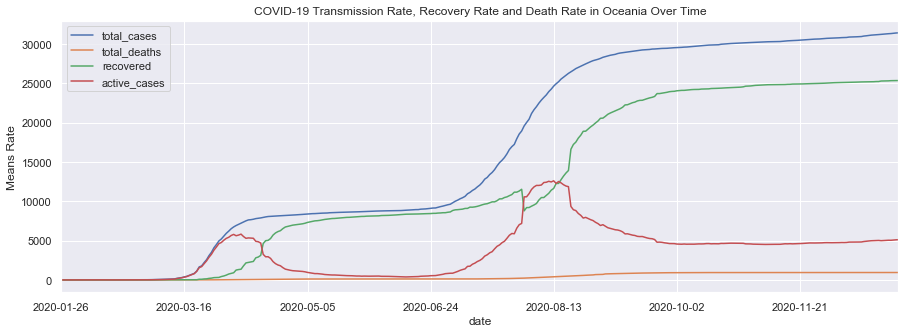

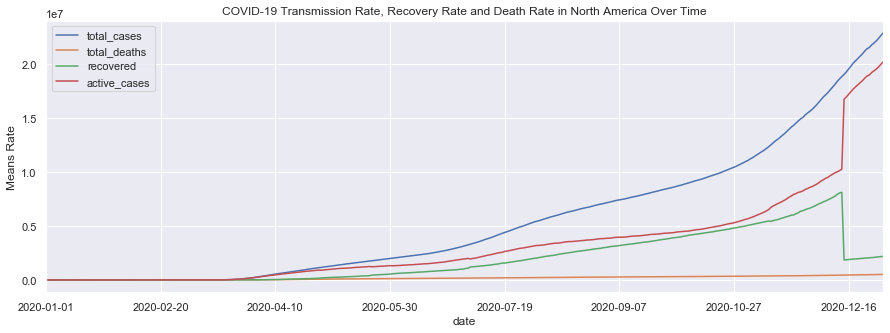

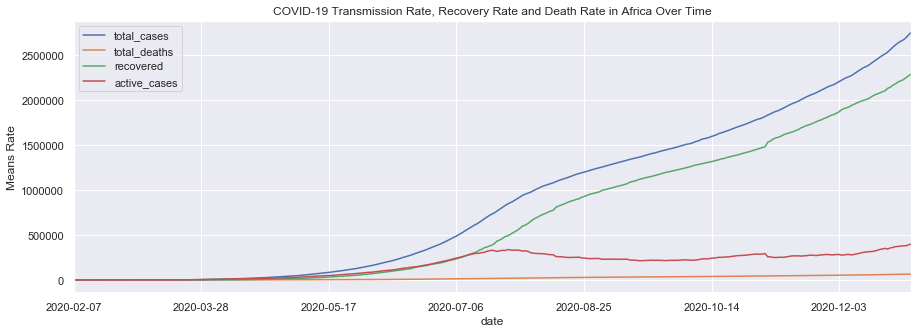

In [52]:
conts = ['Oceania', 'North America', 'Africa']
for i in conts:
    worldwide[worldwide.continent==i].plot(x='date', title='COVID-19 Transmission Rate, Recovery Rate and Death Rate in {} Over Time'.format(i),
                                          figsize=(15,5))
    plt.ylabel('Means Rate')

This Confirms the suspicion outlined earlier about Oceania controlling the spread of the virus well and North America not doing the same.

According to the approximated SIRD model, we realize that if $ \beta(t) - (\gamma(t) + \delta(t)) < 0 $ then the disease is controlled. Otherwise, there is either still an outbreak or another outbreak. So we compute
$$ R_0(t) = \dfrac{\beta(t)}{\gamma(t) + \delta(t)} $$
to see the control of diseases.

From control disease graph, approximated SIRD can become approximated stochastic SIRD which is defined by:
$$ \dfrac{dI_t}{I_t} = (\beta - \gamma - \delta)dt + dB_t $$
$ \qquad $ $$ \dfrac{dR_t}{I_t} = \gamma dt + dB_t $$
$ \qquad $
$$ \dfrac{dD_t}{I_t} = \delta dt +dB_t $$ where $ B_t $ is Random Walk

## Finding R0 for Continents of Interest
<a id="R0"></a>

In [53]:
#globe = rate_map.drop(['continent'], axis=1, inplace=True)
#globe.head()
rate_map.head()

date      continent  beta  gamma  delta
0  2020-01-01  North America   0.0    0.0    0.0
1  2020-01-01  South America   0.0    0.0    0.0
2  2020-01-02  North America   0.0    0.0    0.0
3  2020-01-02  South America   0.0    0.0    0.0
4  2020-01-03  North America   0.0    0.0    0.0

Text(0, 0.5, 'Ratio')

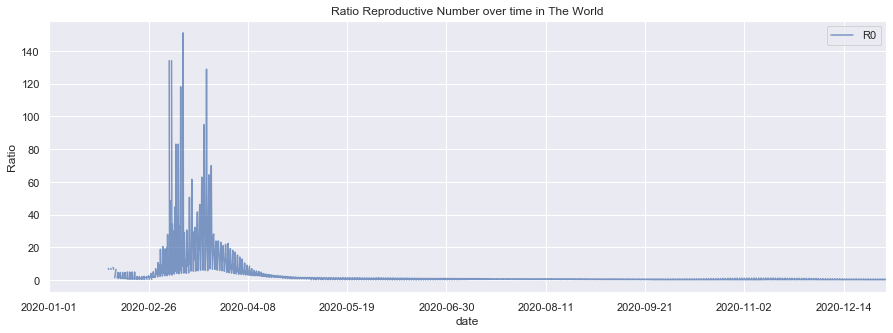

In [54]:
rate_map['R0'] = rate_map.beta.values/(rate_map.gamma.values + rate_map.delta.values)

rate_map.plot(x='date', y='R0', title='Ratio Reproductive Number over time in The World', figsize=(15,5),alpha=0.7)
plt.ylabel('Ratio')

In [55]:
def r0(data=rate_map, continent=None):
    
    '''
        This Function calculates the Values of R0 for the three continents of interest.
        Parameters: data (rate map), continent(continents)
        Returns: Column of R0
    '''
    
    cont = data[data.continent == continent]
    cont['R0'] = cont.beta.values/(cont.gamma.values + cont.delta.values)
    return cont

inf
inf
inf


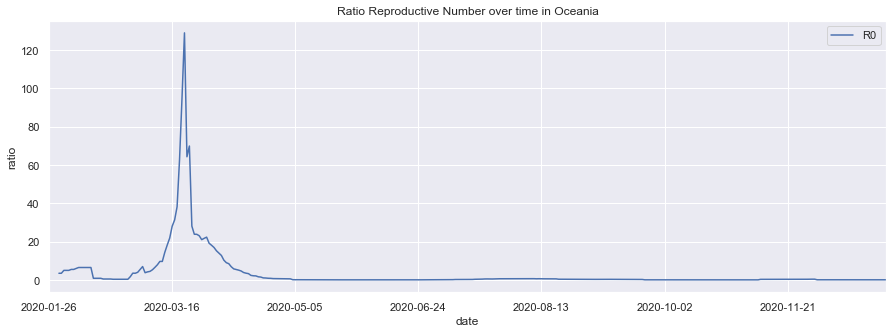

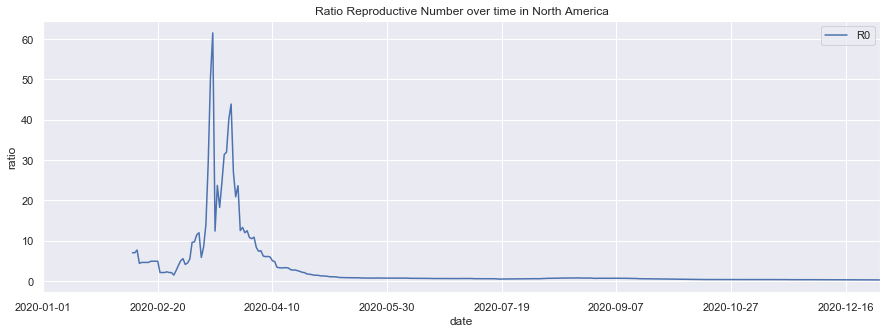

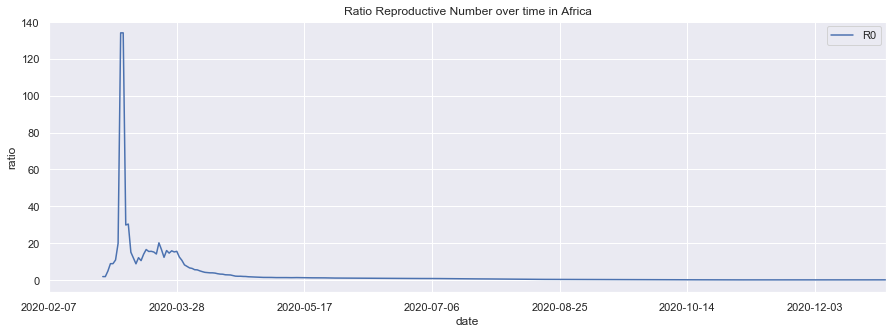

In [56]:
for i in conts:
    conti = r0(continent=i)
    conti.plot(x='date', y='R0', title='Ratio Reproductive Number over time in {}'.format(i), figsize=(15,5))
    plt.ylabel('ratio')
    rnot = (conti['R0'].mean())
    print(rnot)

## SIRD Models for Nigeria, Tanzania and South Africa
<a id="ntsa_sird"></a>
These countries were chosen because:
<ol>
    <li>Nigeria is our main country of interest</li>
    <li>From the bar graph, South Africa can be considered the country in Africa doing the worst with controlling the pandemic</li>
    <li>Also from the bar graph, Tanzania can be considereed the country in Africa doing the best in terms of controlling the pandemic</li>
</ol>

In [57]:
nigeria = geospa[geospa.name=="Nigeria"]

s_africa = geospa[geospa.name=="South Africa"]

tanzania = geospa[geospa.name=="Tanzania"]

### SIRD Model for Nigeria

In [58]:
def cont_det(cont):
    
    '''
        This program is to calculcate the total number of cases, deaths recovrries an active cases in a country.
        
        Parameters: Country dataframe
        returns: Total cases, Total Deaths, Total Recoveries and Number of Active Cases
    '''
    
    ctry = cont.groupby('date')[['total_cases', 'recovered', 'total_deaths', 'active_cases']].agg('sum')
     
    print(' Total Cases: {} \n Total Deaths: {} \n Total Recoveries: {} \n Active Cases: {}'.format(ctry.total_cases.max(), ctry.total_deaths.max(), ctry.recovered.max(), ctry.active_cases.max()))

In [59]:
cont_det(nigeria)

 Total Cases: 87607 
 Total Deaths: 1289 
 Total Recoveries: 73713 
 Active Cases: 22707


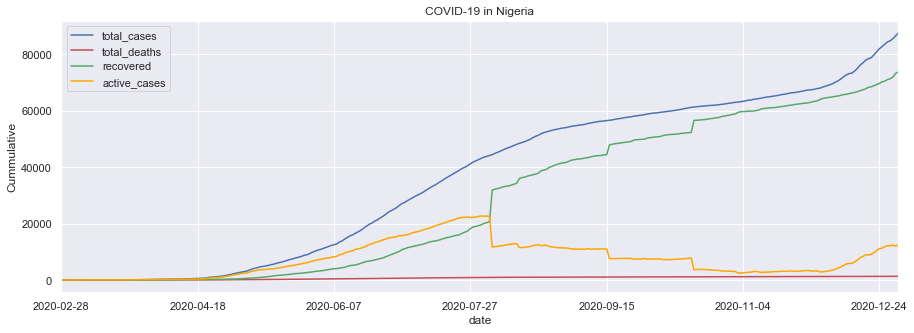

In [60]:
nigeria[['date', 'total_cases', 'total_deaths', 'recovered', 'active_cases']].plot(x='date', title='COVID-19 in Nigeria',
                                                                                   colors=['b', 'r', 'g', 'orange'],
                                                                                   figsize=(15,5))
plt.ylabel('Cummulative');

### Discussion
The total number of 

### SIRD Model for South Africa

In [61]:
cont_det(s_africa)

 Total Cases: 1057161 
 Total Deaths: 28469 
 Total Recoveries: 879671 
 Active Cases: 173590


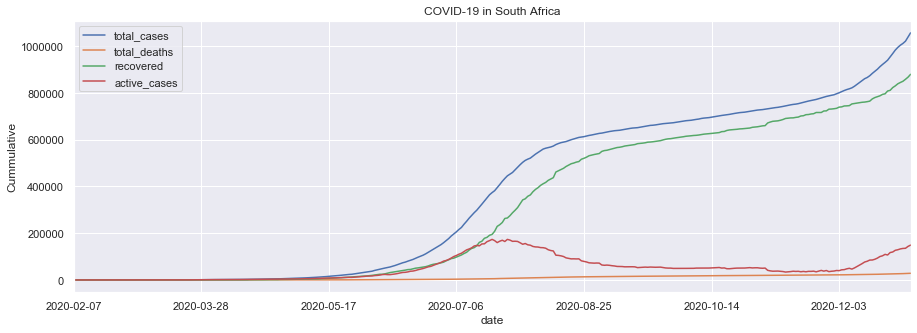

In [62]:
s_africa[['date', 'total_cases', 'total_deaths', 'recovered', 'active_cases']].plot(x='date', title='COVID-19 in South Africa', 
                                                                                  figsize=(15,5))
plt.ylabel('Cummulative');

### Discussion

### SIRD Model for South Africa

In [63]:
cont_det(tanzania)

 Total Cases: 509 
 Total Deaths: 21 
 Total Recoveries: 183 
 Active Cases: 305


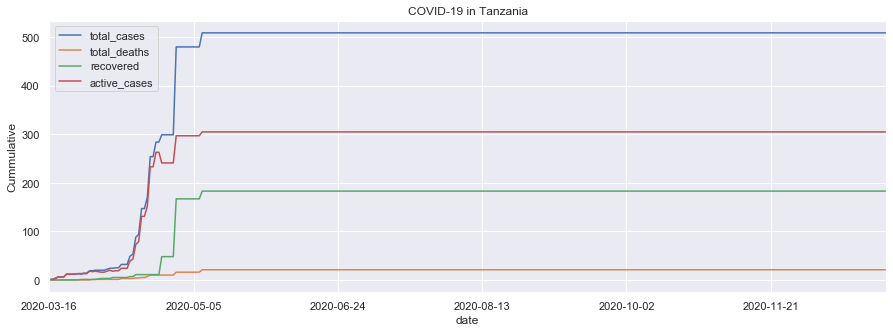

In [64]:
tanzania[['date', 'total_cases', 'total_deaths', 'recovered', 'active_cases']].plot(x='date', title='COVID-19 in Tanzania', 
                                                                                  figsize=(15,5))
plt.ylabel('Cummulative');

In [65]:
tanzania.tail(10)

date      name continent  total_cases  total_deaths  recovered  \
47645  2020-12-22  Tanzania    Africa          509            21        183   
47806  2020-12-23  Tanzania    Africa          509            21        183   
47967  2020-12-24  Tanzania    Africa          509            21        183   
48128  2020-12-25  Tanzania    Africa          509            21        183   
48289  2020-12-26  Tanzania    Africa          509            21        183   
48450  2020-12-27  Tanzania    Africa          509            21        183   
48611  2020-12-28  Tanzania    Africa          509            21        183   
48772  2020-12-29  Tanzania    Africa          509            21        183   
48933  2020-12-30  Tanzania    Africa          509            21        183   
49095  2020-12-31  Tanzania    Africa          509            21        183   

       active_cases      beta     gamma     delta  
47645           305  0.599214  0.359528  0.041257  
47806           305  0.599214  0.359528  0.041257  
47967           305  0.599214  0.359528  0.041257  
48128           305  0.599214  0.359528  0.041257  
48289           305  0.599214  0.359528  0.041257  
48450           305  0.599214  0.359528  0.041257  
48611           305  0.599214  0.359528  0.041257  
48772           305  0.599214  0.359528  0.041257  
48933           305  0.599214  0.359528  0.041257  
49095           305  0.599214  0.359528  0.041257

### Discussion
DIRTY DATA!!!!

## Find R0 For Nigeria
<a id="n_R0"></a>

Text(0, 0.5, 'Rate')

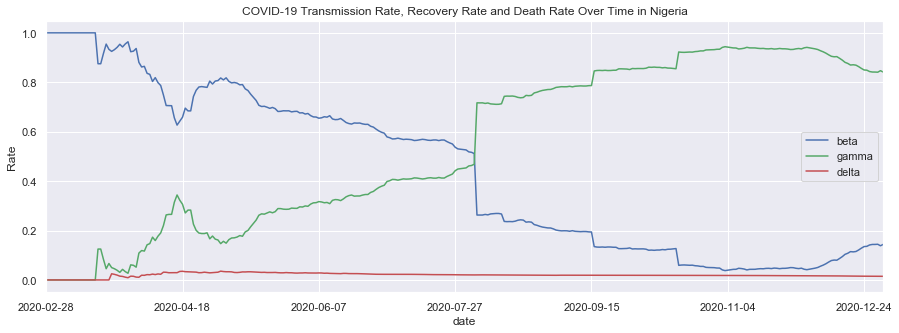

In [66]:
nigeria[['date', 'beta', 'gamma', 'delta']].plot(x='date', title='COVID-19 Transmission Rate, Recovery Rate and Death Rate Over Time in Nigeria',
                                                color=['b', 'g', 'r'], figsize=(15,5))
plt.ylabel('Rate')

In [67]:
def r0_country(data=None):
    return data.beta.values/(data.gamma.values + data.delta.values)

In [68]:
nigeria['R0'] = r0_country(data=nigeria)

In [69]:
nigeria.head()

date     name continent  total_cases  total_deaths  recovered  \
1303  2020-02-28  Nigeria    Africa            1             0          0   
1369  2020-02-29  Nigeria    Africa            1             0          0   
1440  2020-03-01  Nigeria    Africa            1             0          0   
1513  2020-03-02  Nigeria    Africa            1             0          0   
1590  2020-03-03  Nigeria    Africa            1             0          0   

      active_cases  beta  gamma  delta   R0  
1303             1   1.0    0.0    0.0  inf  
1369             1   1.0    0.0    0.0  inf  
1440             1   1.0    0.0    0.0  inf  
1513             1   1.0    0.0    0.0  inf  
1590             1   1.0    0.0    0.0  inf

In [70]:
nigeria['R0'].mean()

inf

Text(0, 0.5, 'Ratio')

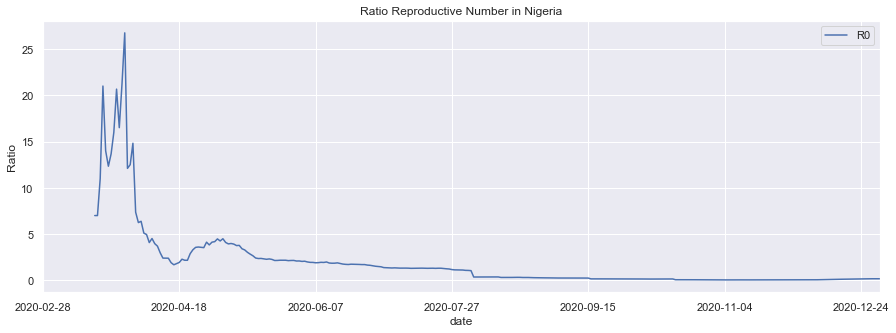

In [71]:
nigeria.plot(x='date', y='R0', title='Ratio Reproductive Number in Nigeria', figsize=(15,5))
plt.ylabel('Ratio')

In [72]:
nigeria.head()

date     name continent  total_cases  total_deaths  recovered  \
1303  2020-02-28  Nigeria    Africa            1             0          0   
1369  2020-02-29  Nigeria    Africa            1             0          0   
1440  2020-03-01  Nigeria    Africa            1             0          0   
1513  2020-03-02  Nigeria    Africa            1             0          0   
1590  2020-03-03  Nigeria    Africa            1             0          0   

      active_cases  beta  gamma  delta   R0  
1303             1   1.0    0.0    0.0  inf  
1369             1   1.0    0.0    0.0  inf  
1440             1   1.0    0.0    0.0  inf  
1513             1   1.0    0.0    0.0  inf  
1590             1   1.0    0.0    0.0  inf

## SIRD Model for Nigeria
<a id="SIRD"></a>

In [73]:
merged_geo_2.groupby(['date', 'name', 'continent'])['pop_est', 'total_cases', 'total_deaths', 'recovered', 'active_cases'].agg('sum')

pop_est  total_cases  total_deaths  \
date       name      continent                                             
2020-01-01 Argentina South America   44293293            0             0   
           Mexico    North America  124574795            0             0   
2020-01-02 Argentina South America   44293293            0             0   
           Mexico    North America  124574795            0             0   
2020-01-03 Argentina South America   44293293            0             0   
...                                       ...          ...           ...   
2020-12-31 Vietnam   Asia            96160163         1465            35   
           Yemen     Asia            28036829         2099           610   
           Zambia    Africa          15972000        20725           388   
           Zimbabwe  Africa          13805084        13867           363   
           eSwatini  Africa           1467152         9358           205   

                                    recovered  active_cases  
date       name      continent                               
2020-01-01 Argentina South America          0             0  
           Mexico    North America          0             0  
2020-01-02 Argentina South America          0             0  
           Mexico    North America          0             0  
2020-01-03 Argentina South America          0             0  
...                                       ...           ...  
2020-12-31 Vietnam   Asia                1325           105  
           Yemen     Asia                1394            95  
           Zambia    Africa             18660          1677  
           Zimbabwe  Africa             11250          2254  
           eSwatini  Africa              7073          2080  

[49115 rows x 5 columns]

In [74]:
test2.head()

date       name  dead  recovered  infective  susceptible  beta  \
0  2020-01-01  Argentina     0          0          0     44293293   0.0   
1  2020-01-01     Mexico     0          0          0    124574795   0.0   
2  2020-01-02  Argentina     0          0          0     44293293   0.0   
3  2020-01-02     Mexico     0          0          0    124574795   0.0   
4  2020-01-03  Argentina     0          0          0     44293293   0.0   

   gamma  delta  
0    0.0    0.0  
1    0.0    0.0  
2    0.0    0.0  
3    0.0    0.0  
4    0.0    0.0

In [75]:
nigeria = test2[test2.name=="Nigeria"]

In [76]:
nigeria.head()

date     name  dead  recovered  infective  susceptible  beta  \
1303  2020-02-28  Nigeria     0          0          1    190632260   1.0   
1369  2020-02-29  Nigeria     0          0          1    190632260   1.0   
1440  2020-03-01  Nigeria     0          0          1    190632260   1.0   
1513  2020-03-02  Nigeria     0          0          1    190632260   1.0   
1590  2020-03-03  Nigeria     0          0          1    190632260   1.0   

      gamma  delta  
1303    0.0    0.0  
1369    0.0    0.0  
1440    0.0    0.0  
1513    0.0    0.0  
1590    0.0    0.0

### For Standard Incidence in Nigeria

In [77]:
#set R0 = 3.5
R0 = 3.5
#set gamma = 1/14 since recoveries happen in two weeks
#gamma = 0.8414
#beta = 0.25919 #gamma * R0
#delta = 0.0147134361409

In [78]:
def get_beta_gamma(R=3.5,recovery_time=14):
    """
    Returns beta and gamma based on recovery time and infectious power R"""
    gamma = 1./recovery_time
    beta = R*gamma
    return beta,gamma
#beta,gamma = get_beta_gamma()
#print("beta = {}\ngamma = {}".format(beta,gamma))

In [79]:
N = 190632260
times = np.arange(250)
Us = np.empty((250, 4))
I0, R0, D0 = 1, 0, 0
S0 = N - I0 - R0 - D0
#S0 = 190632260
Us[0] = np.array([S0, I0, R0, D0])

In [80]:
def rhs(t, U, beta, gamma, delta):
    S, I, R, D = U[0], U[1], U[2], U[3]
    return np.array([-beta * S * I/N, beta * S * I/N - I *(gamma + delta), gamma * I, delta * I])

In [81]:
from scipy.integrate import ode
integrator = ode(rhs)
#set initial conditions parameters
beta, gamma = get_beta_gamma(R=3, recovery_time=14)
delta = 0.02 * gamma
integrator.set_initial_value(Us[0], 0)
integrator.set_f_params(beta, gamma, delta)

In [82]:
for i in range(len(times)-1):
    t = times[i+1]
    integrator.integrate(t)
    Us[i+1] = integrator.y

In [83]:
S, I, R, D = Us[:,0], Us[:,1], Us[:,2], Us[:,3]

Text(0, 0.5, 'Population Estimate')

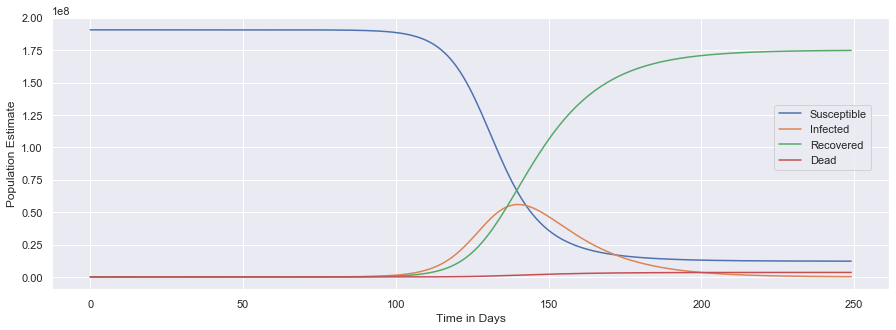

In [84]:
plt.figure(figsize=(15,5))
plt.plot(times,S,label='Susceptible')
plt.plot(times,I,label='Infected')
plt.plot(times,R,label='Recovered')
plt.plot(times,D,label='Dead')
plt.legend(bbox_to_anchor=[0.985,0.7])
plt.xlabel('Time in Days')
plt.ylabel('Population Estimate')